In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import genfromtxt
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.models import Model,Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense


Using TensorFlow backend.


In [2]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    print("Inside triplet loss")
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    print(anchor)
    print(positive)
    print(negative)
    ### START CODE HERE ### (˜ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    ### END CODE HERE ###
    
    print("Entering the function")
    return loss


In [3]:
def faceRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)
    
             
    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [4]:
_FLOATX = 'float32'
def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS_mod = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3'
]
conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3]
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS_mod
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS_mod:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    flat_input=embedding.flatten()
    return embedding


In [5]:

FRmodel = faceRecoModel(input_shape=(3, 350, 350))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

Inside triplet loss
Tensor("loss/lambda_1_loss/strided_slice:0", shape=(128,), dtype=float32)
Tensor("loss/lambda_1_loss/strided_slice_1:0", shape=(128,), dtype=float32)
Tensor("loss/lambda_1_loss/strided_slice_2:0", shape=(128,), dtype=float32)
Entering the function


In [6]:
 def show_images(image_path_original,image_path_check):
    
    imageA=mpimg.imread(image_path_original)
    imageB=mpimg.imread(image_path_check)
    fig = plt.figure("Comparison")
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

In [7]:
def verify(image_path_original, image_path_check, model): 
    
    encoding_original = img_to_encoding(image_path_original,model)
    encoding_check = img_to_encoding(image_path_check,model)
    
    dist = np.linalg.norm(encoding_original-encoding_check)
    dist = dist/256
    # setup the figure
    
    show_images(image_path_original,image_path_check)
    print ("Distance is " , dist)
    if dist < 1:
        print("It's similar")          
    else:
        print("It's not similar")
    

In [8]:

def verify_ml_approach(image_path_original,image_path_check):
    verify(image_path_original, image_path_check, FRmodel)
    
  

In [11]:
def load_train_data():
    dataset = np.genfromtxt("data.csv", dtype="U" ,delimiter="," )
    X = dataset[:,0:2]
    Y = dataset[:,2]
    Y= [int(i) for i in Y]
    m=len(Y)
    return X,Y,m


In [12]:
def getimagePath(name):
    return('images/'+str(name)+'.png')

In [13]:
def getSimpleModel():
    inputs=Input(shape=(128,))
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(11, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [14]:
def getSeqModel():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    return model

In [15]:
def prepare_train_data(X,Y,m,classes=11):
    dat=np.zeros((1,128))
    data=np.zeros((m,128))
    labels=np.zeros((m,classes))
    row=0
    for [ori,chk] in X:
        ori_encoding=img_to_encoding(getimagePath(ori), FRmodel)
        chk_encoding=img_to_encoding(getimagePath(chk), FRmodel)
        dat=(ori_encoding-chk_encoding)
        data[row,:]=dat
        labels[row,Y[row]]=1
        row=row+1  
    return data,labels

In [26]:
def train_2nd_model():
    X,Y,m=load_train_data()
    data,labels=prepare_train_data(X,Y,m)

    Smodel=getSimpleModel()
    Smodel.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    Smodel.fit(data,labels,epochs=100 )  # starts training
    score = Smodel.evaluate(data,labels)
    return Smodel
    

In [27]:
Smodel=train_2nd_model()

Epoch 1/100
22/22 [==============================] - 1s 24ms/step - loss: 2.3739 - acc: 0.4091
Epoch 2/100
22/22 [==============================] - 0s 716us/step - loss: 2.3307 - acc: 0.6364
Epoch 3/100
22/22 [==============================] - 0s 0us/step - loss: 2.2957 - acc: 0.6364
Epoch 4/100
22/22 [==============================] - 0s 0us/step - loss: 2.2622 - acc: 0.6364
Epoch 5/100
22/22 [==============================] - 0s 823us/step - loss: 2.2288 - acc: 0.6364
Epoch 6/100
22/22 [==============================] - 0s 259us/step - loss: 2.1939 - acc: 0.6364
Epoch 7/100
22/22 [==============================] - 0s 91us/step - loss: 2.1595 - acc: 0.6364
Epoch 8/100
22/22 [==============================] - 0s 215us/step - loss: 2.1244 - acc: 0.6364
Epoch 9/100
22/22 [==============================] - 0s 181us/step - loss: 2.0887 - acc: 0.6364
Epoch 10/100
22/22 [==============================] - 0s 218us/step - loss: 2.0517 - acc: 0.6364
Epoch 11/100
22/22 [=========================

Epoch 87/100
22/22 [==============================] - 0s 281us/step - loss: 0.5813 - acc: 0.7727
Epoch 88/100
22/22 [==============================] - 0s 141us/step - loss: 0.5702 - acc: 0.8182
Epoch 89/100
22/22 [==============================] - 0s 191us/step - loss: 0.5597 - acc: 0.8182
Epoch 90/100
22/22 [==============================] - 0s 115us/step - loss: 0.5488 - acc: 0.8182
Epoch 91/100
22/22 [==============================] - 0s 179us/step - loss: 0.5384 - acc: 0.8182
Epoch 92/100
22/22 [==============================] - 0s 0us/step - loss: 0.5282 - acc: 0.8636
Epoch 93/100
22/22 [==============================] - 0s 349us/step - loss: 0.5181 - acc: 0.8182
Epoch 94/100
22/22 [==============================] - 0s 0us/step - loss: 0.5080 - acc: 0.8636
Epoch 95/100
22/22 [==============================] - 0s 398us/step - loss: 0.4974 - acc: 0.9091
Epoch 96/100
22/22 [==============================] - 0s 0us/step - loss: 0.4878 - acc: 0.9091
Epoch 97/100
22/22 [================

In [28]:
 def predict(image_path_original,image_path_check,FRmodel,Smodel):
    encoding_original = img_to_encoding(image_path_original,FRmodel)
    encoding_check = img_to_encoding(image_path_check,FRmodel)
    dat=encoding_original-encoding_check
    
    prediction = Smodel.predict_on_batch(dat)
    return prediction

In [29]:
def predict_2_models(image_path_original,image_path_check):
    show_images(image_path_original,image_path_check)
    print("Scoring...............................")
    prediction = predict(image_path_original, image_path_check, FRmodel,Smodel)
    score = np.argmax(prediction)
    print("Score of similarity is ", score)

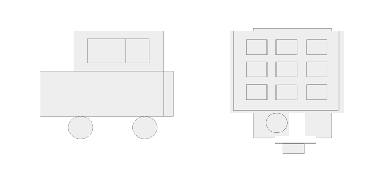

Distance is  0.0021836606319993734
It's similar


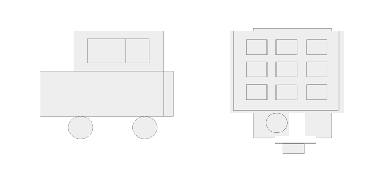

Scoring...............................
Score of similarity is  2


In [30]:
verify_ml_approach("images/image2.png", "images/image1_modified.png")
predict_2_models("images/image2.png", "images/image1_modified.png")

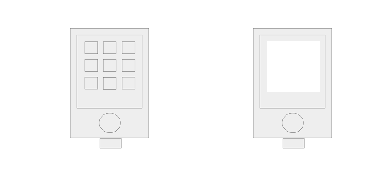

Distance is  0.0013810261152684689
It's similar


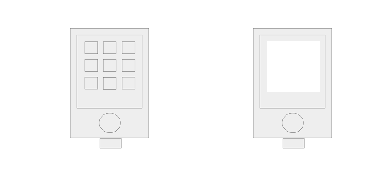

Scoring...............................
Score of similarity is  8


In [32]:
verify_ml_approach("images/image1.png", "images/image1_modified1.png")
predict_2_models("images/image1.png", "images/image1_modified1.png")

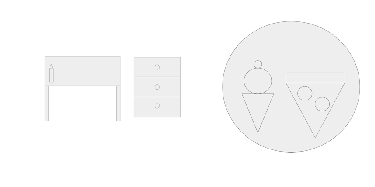

Distance is  0.0019806751515716314
It's similar


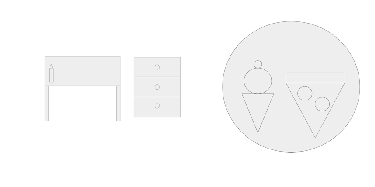

Scoring...............................
Score of similarity is  0


In [34]:
verify_ml_approach("images/image3.png", "images/image4.png")
predict_2_models("images/image3.png", "images/image4.png")

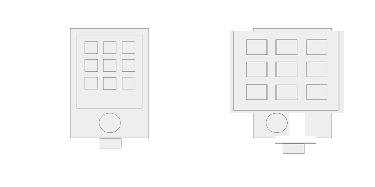

Distance is  0.0017940215766429901
It's similar


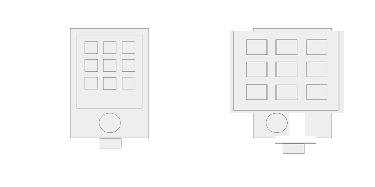

Scoring...............................
Score of similarity is  0


In [35]:
verify_ml_approach("images/image1.png", "images/image1_modified.png")
predict_2_models("images/image1.png", "images/image1_modified.png")